In [1]:
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)

In [2]:
import torchvision
import dlib
from PIL import Image
from imutils import face_utils
from src.data.dataprep_mediapipe import *
from src.data.imgutils import *
from src.features.features_extractors_mediapipe import *
import pandas as pd
import seaborn as sns

In [3]:
HOME

'/Users/samirchar/Google_Drive/Masters/DSI Scholars/stroke_detection'

In [69]:
DUMMY_DATA_PATH = 'data/dummy_data/'
DUMMY_DATA_2_PATH = DUMMY_DATA_PATH+'samir/'
video = torchvision.io.read_video('data/raw/29_face_smile.mov')

/opt/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


In [70]:
FPS = video[2]['video_fps']
frames = video[0].transpose(1,2)
num_frames,H,W,C = frames.size()
print(num_frames)

108


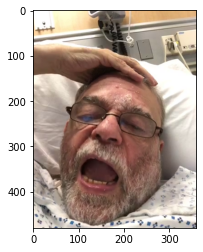

In [71]:
plt.imshow(frames[31])

In [72]:
landmarks_left_to_right_mapping = {37:267,
                                    72:302,
                                    38:268,
                                    82:312,
                                    87:317,
                                    86:316,
                                    85:315,
                                    84:314,
                                    39:269,
                                    73:303,
                                    41:271,
                                    81:311,
                                    178:402,
                                    179:403,
                                    180:404,
                                    181:405,
                                    40:270,
                                    74:304,
                                    42:272,
                                    80:310,
                                    88:318,
                                    89:319,
                                    90:320,
                                    91:321,
                                    185:409,
                                    184:408,
                                    183:407,
                                    191:415,
                                    95:324,
                                    96:325,
                                    77:307,
                                    146:375}


bo = BarycentricOperations(landmarks_left_to_right_mapping,
                           triangle_indices = [70,300,4])

# Run all Video

In [73]:
import cv2
import time
import uuid 
#Constants
SIZE = 1024
OPTICAL_FLOW_THRESHOLD = 3
SAVE_VIDEO = True

#Init
selected_landmarks = -1
op = OpticalFlow(flow_threshold = OPTICAL_FLOW_THRESHOLD)
ofs = OpticalFlowSymmetry()                  

uuid_ = str(uuid.uuid1()).split('-')[0]


frame_prev = frames[0]
original_frames = [frame_prev]

                  
h,w,_ = frame_prev.shape
detector = FaceMeshDetector(frame_height=h,
                            frame_width=w,
                            desiredFaceWidthHeight= (SIZE,SIZE),
                            yaw_correction=True)


frame_prev,faces_prev = detector.process(frame_prev)
face_prev = faces_prev[0]
gray_frame_prev = cv2.cvtColor(frame_prev, cv2.COLOR_RGB2GRAY)
frame_drawn_prev = detector.draw_faces(frame_prev,faces_prev)
processed_landmarks_prev = face_prev['processed_landmarks']

of_temp = []
left_movement_temp = []
right_movement_temp = []
left_magnitudes_temp = []
right_magnitudes_temp = []
num_frames = 0
time_start = time.time()

left_of_frames = []
right_of_frames = []
frames_drawn = []
all_face_objs = []
mouth_barycentric_asymmetry = []

for frame in frames:
    original_frames.append(frame)    
    
    frame,faces = detector.process(frame)
    face = faces[0]
    
    all_face_objs.append(face)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame_drawn = detector.draw_faces(frame,faces)
    processed_landmarks = face['processed_landmarks']


    #Optical Flow
    re_prev = ROIExtractor(frame_prev,processed_landmarks_prev,debug=False)
    re = ROIExtractor(frame,processed_landmarks,debug=False)

    left_mouth_prev,left_mouth_prev_bounds = re_prev.left_mouth()
    right_mouth_prev,right_mouth_prev_bounds = re_prev.right_mouth()
    left_mouth,_ = re.left_mouth()
    right_mouth,_ = re.right_mouth()
    
    #left_mouth_prev,left_mouth_prev_bounds = re_prev.left_face()
    #right_mouth_prev,right_mouth_prev_bounds = re_prev.right_face()
    #left_mouth,_ = re.left_face()
    #right_mouth,_ = re.right_face()
  

    '''
    left_mouth,_ = re.left_mouth(project_to = left_project_coords)
    right_mouth,_ = re.right_mouth(project_to = right_project_coords)

    left_project_coords = [[left_mouth_prev_bounds[0],left_mouth_prev_bounds[2]],
                          [left_mouth_prev_bounds[1],left_mouth_prev_bounds[2]],
                          [left_mouth_prev_bounds[1],left_mouth_prev_bounds[3]],
                          [left_mouth_prev_bounds[0],left_mouth_prev_bounds[3]]]


    right_project_coords = [[right_mouth_prev_bounds[0],right_mouth_prev_bounds[2]],
                            [right_mouth_prev_bounds[1],right_mouth_prev_bounds[2]],
                            [right_mouth_prev_bounds[1],right_mouth_prev_bounds[3]],
                            [right_mouth_prev_bounds[0],right_mouth_prev_bounds[3]]]'''

    ##Size correction.
    left_mouth = cv2.resize(left_mouth,(left_mouth_prev.shape[1],left_mouth_prev.shape[0]))
    right_mouth = cv2.resize(right_mouth,(right_mouth_prev.shape[1],right_mouth_prev.shape[0]))                      
    
    
    left_magnitude, left_angle = op.compute_dense_flow(left_mouth_prev,left_mouth)
    left_magnitude = op.filter_flow_magnitude_noise(left_magnitude)
    left_rgb_of = op.get_rgb_optical_flow(left_magnitude, left_angle)

    right_magnitude, right_angle = op.compute_dense_flow(right_mouth_prev,right_mouth)
    right_magnitude = op.filter_flow_magnitude_noise(right_magnitude)
    right_rgb_of = op.get_rgb_optical_flow(right_magnitude, right_angle)
    
    left_of_frames.append(left_rgb_of)
    right_of_frames.append(right_rgb_of)
    
    left_movement_score = ofs.movement_score([left_magnitude])
    right_movement_score = ofs.movement_score([right_magnitude])


    of_mouth_symmetry_score = ofs.symmetry_score([left_magnitude],[right_magnitude],lambda_=10,ret='abs_diff')

    #Append to temporal lists
    of_temp.append(of_mouth_symmetry_score)
    right_movement_temp.append(right_movement_score)
    left_movement_temp.append(left_movement_score)
    right_magnitudes_temp.append(right_magnitude)
    left_magnitudes_temp.append(left_magnitude)

    '''
    nose_mouth_features_ = nose_mouth_features(processed_landmarks)

    lmnx,lmny,lmnd,theta,rmnx,rmny,rmnd,phi = nose_mouth_features_

    h_eb_eb_devs = h_eyebrow_eyebrow_deviation(processed_landmarks, 
                            exclude=[0,1,2])
    h_eb_eb_devs = np.round(h_eb_eb_devs,2)


    bo = BarycentricOperations(landmarks_left_to_right_mapping,
                       triangle_indices = [68,69,70])
    barycentric_asymmetry = bo.global_asymmetry_index(
    processed_landmark_dict_to_array(processed_landmarks))
    '''
    mouth_barycentric_asymmetry.append(bo.global_asymmetry_index(processed_landmarks))

    data_annotator = annotate_data(initial_h=int(frame.shape[0]*.1), interval_h=int(frame.shape[0]*.1))
    #frame_drawn = data_annotator.annotate(frame_drawn,'theta',round(theta))
    #frame_drawn = data_annotator.annotate(frame_drawn,'phi',round(phi))
    #frame_drawn = data_annotator.annotate(frame_drawn,'h_eb_dev',h_eb_eb_devs)
    #frame_drawn = data_annotator.annotate(frame_drawn,'b_asymmetry',round(barycentric_asymmetry,2))
    frame_drawn = data_annotator.annotate(frame_drawn,'of_m_s',round(of_mouth_symmetry_score,5))
    
    frame_drawn = cv2.cvtColor(frame_drawn, cv2.COLOR_RGB2BGR)
    cv2.imshow('Input', frame_drawn)
    
    
    frames_drawn.append(frame_drawn)
    
    num_frames+=1

    c = cv2.waitKey(1)
    if c == 27:
        break
       
    # Updates previous frame info
    frame_prev = frame
    gray_frame_prev = gray_frame 
    frame_drawn_prev,face_prev = frame_drawn,face
    processed_landmarks_prev = processed_landmarks

    


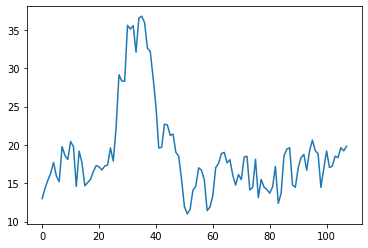

In [74]:
plt.plot(mouth_barycentric_asymmetry)
plt.show()

In [75]:
'''
left_magnitudes_temp_flipped = [cv2.flip(i,1) for i in left_magnitudes_temp]

right_magnitudes_temp_cropped = []
for i in range(len(left_magnitudes_temp_flipped)):
    hlf,wlf = left_magnitudes_temp_flipped[i].shape
    hrf,wrf = right_magnitudes_temp[i].shape
    h_i = min(hlf,hrf)
    w_i = min(wlf,wrf)
    
    right_magnitudes_temp_cropped.append(right_magnitudes_temp[i][:h_i,:w_i])

bilateral_differences = [l-r for l,r in zip(left_magnitudes_temp_flipped,right_magnitudes_temp_cropped)]
'''

'\nleft_magnitudes_temp_flipped = [cv2.flip(i,1) for i in left_magnitudes_temp]\n\nright_magnitudes_temp_cropped = []\nfor i in range(len(left_magnitudes_temp_flipped)):\n    hlf,wlf = left_magnitudes_temp_flipped[i].shape\n    hrf,wrf = right_magnitudes_temp[i].shape\n    h_i = min(hlf,hrf)\n    w_i = min(wlf,wrf)\n    \n    right_magnitudes_temp_cropped.append(right_magnitudes_temp[i][:h_i,:w_i])\n\nbilateral_differences = [l-r for l,r in zip(left_magnitudes_temp_flipped,right_magnitudes_temp_cropped)]\n'

In [76]:
movement_df = pd.DataFrame({'left_movement': left_movement_temp,
              'right_movement':right_movement_temp,
                           'time':np.arange(len(left_movement_temp))/FPS})

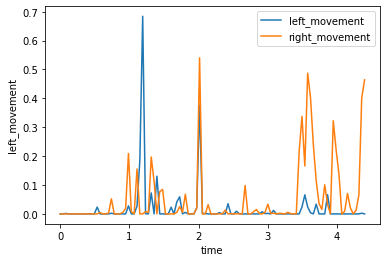

In [77]:
sns.lineplot(x=movement_df['time'],y=movement_df['left_movement'],label = 'left_movement')
sns.lineplot(x=movement_df['time'],y=movement_df['right_movement'],label = 'right_movement')
plt.legend()
#plt.xlim(4,6)
plt.show()

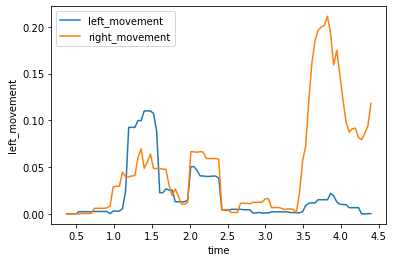

In [78]:
sns.lineplot(x=movement_df['time'],y=movement_df['left_movement'].rolling(10).mean(),label = 'left_movement')
sns.lineplot(x=movement_df['time'],y=movement_df['right_movement'].rolling(10).mean(),label = 'right_movement')
plt.legend()
plt.show()

In [79]:
movement_df.apply(lambda x: x[x>0].describe())

,left_movement,right_movement,time
count,34.000000,65.000000,107.000000
mean,0.058191,0.087727,2.219167
std,0.131721,0.135450,1.275291
min,0.000103,0.000063,0.041096
25%,0.002439,0.003064,1.130131
50%,0.022326,0.018827,2.219167
75%,0.039955,0.113253,3.308202
max,0.684319,0.540340,4.397238


In [80]:
movement_df.apply(lambda x: x.describe())

,left_movement,right_movement,time
count,108.000000,108.000000,108.000000
mean,0.018319,0.052799,2.198619
std,0.078028,0.113292,1.287154
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.099309
50%,0.000000,0.001294,2.198619
75%,0.001746,0.032787,3.297928
max,0.684319,0.540340,4.397238


In [81]:
movement_df.sum()

left_movement       1.978498
right_movement      5.702285
time              237.450833
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


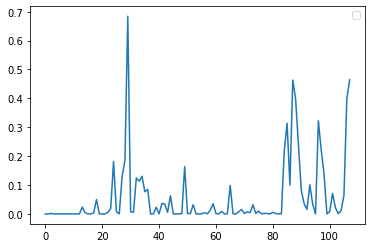

In [82]:
plt.plot(of_temp)
plt.legend()
plt.show()

In [83]:
np.array(of_temp).mean()

0.057124615

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


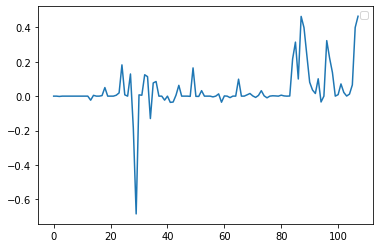

In [84]:

plt.plot(np.array(right_movement_temp)-np.array(left_movement_temp))
plt.legend()
plt.show()

In [61]:

#Save Videos
video_name = f'data/created_videos/processed_video_{uuid_}.avi'
video = cv2.VideoWriter(video_name, 0, FPS, (SIZE,SIZE))

if SAVE_VIDEO:
    for i in frames_drawn:
        video.write(i)
        


In [16]:
frames_drawn[0].shape

(256, 256, 3)

In [17]:

#Save Videos
height, width,_ = original_frames[0].shape
video_name = f'created_videos/raw_video_{uuid_}.avi'
video = cv2.VideoWriter(video_name, 0, FPS, (width,height))

if SAVE_VIDEO:
    for i in original_frames:
        video.write(i)

        
        
left_of_frames = [cv2.resize(i,(114,114)) for i in left_of_frames]
right_of_frames = [cv2.resize(i,(114,114)) for i in right_of_frames]


#Save Videos
height = width = SIZE
video_name = f'created_videos/left_mouth_{uuid_}.avi'
video = cv2.VideoWriter(video_name, 0, FPS, (114,114))

if SAVE_VIDEO:
    for i in left_of_frames:
        video.write(i)


#Save Videos
height = width = SIZE
video_name = f'created_videos/right_mouth_{uuid_}.avi'
video = cv2.VideoWriter(video_name, 0, FPS, (114,114))

if SAVE_VIDEO:
    for i in right_of_frames:
        video.write(i)


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'write'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'
